In [1]:
pip install tensorflow

In [2]:
pip install keras

In [3]:
!pip uninstall tf-keras

Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/tf_keras-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tf_keras/*
Proceed (Y/n)? Y
  Successfully uninstalled tf_keras-2.17.0


In [4]:
pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0


In [5]:
!pip uninstall tf-keras

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
def resize(input_image, input_mask):
    return tf.image.resize(input_image, (128, 128)), tf.image.resize(input_mask, (128, 128))

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
    return tf.cast(input_image, tf.float32) / 255.0, input_mask - 1

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

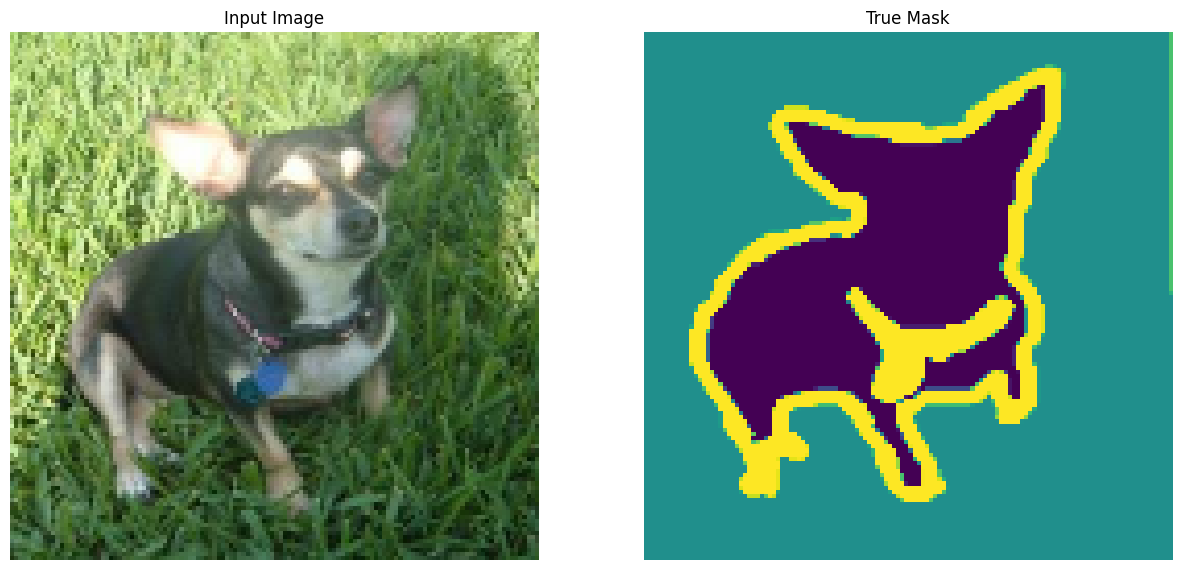

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

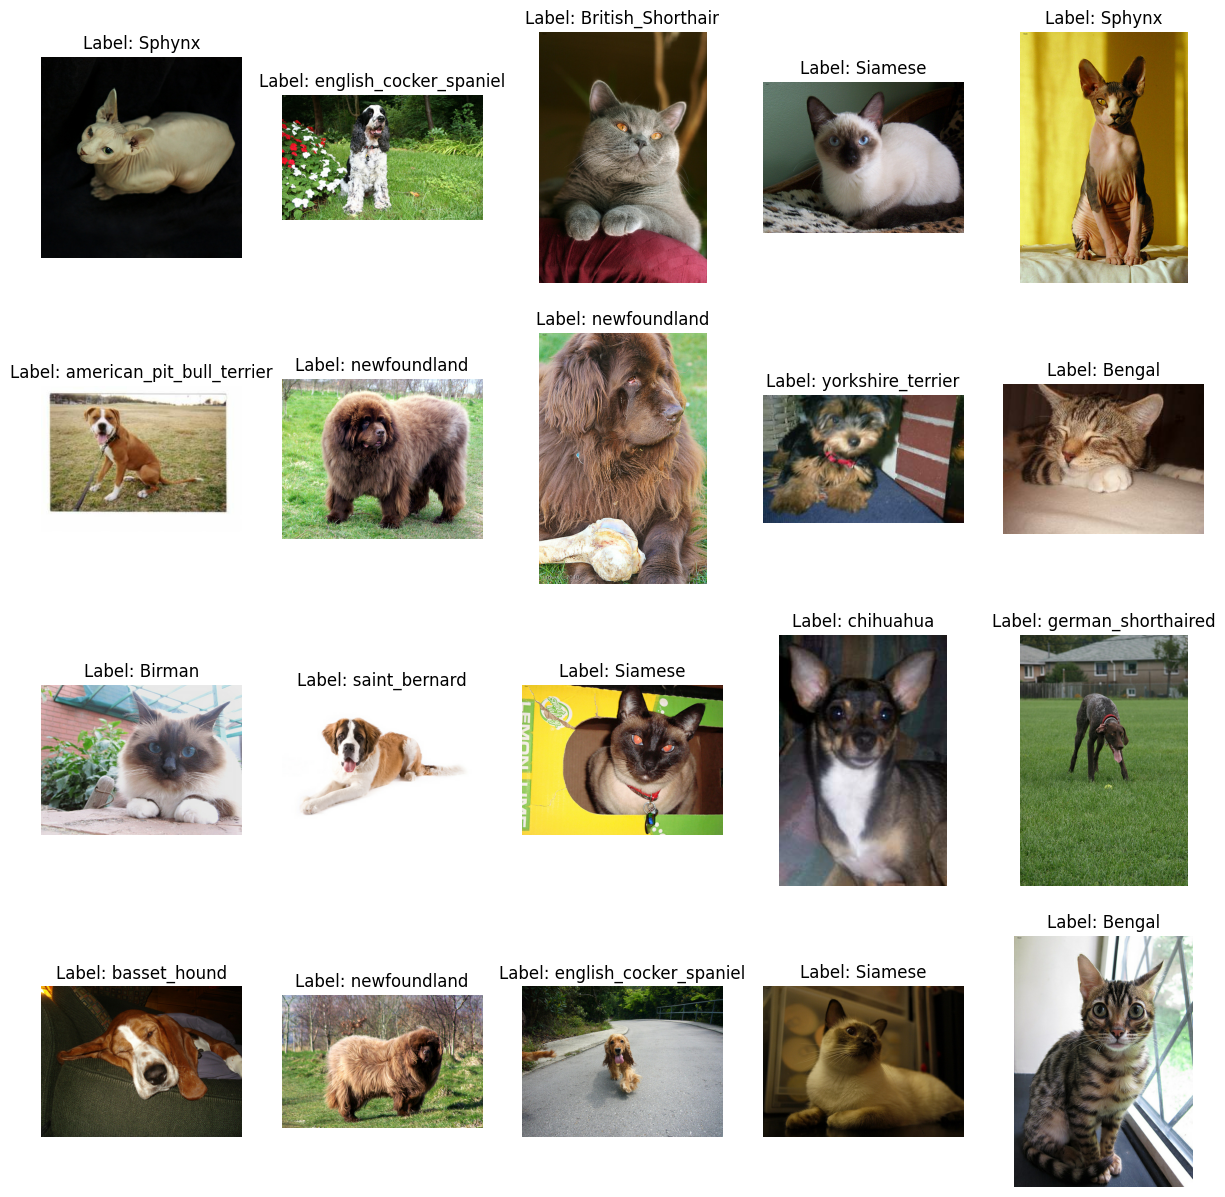

In [ ]:

def visualize_samples(dataset, num_samples=20):
    plt.figure(figsize=(15, 15))
    for i, datapoint in enumerate(dataset.take(num_samples)):
        image, mask = datapoint["image"], datapoint["segmentation_mask"]
        plt.subplot(4, 5, i + 1)
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.title("Label: {}".format(info.features["label"].int2str(datapoint["label"])))
        plt.axis("off")
    plt.show()

# Görselleri görselleştir
visualize_samples(dataset["train"])

In [ ]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
from tensorflow.keras import layers, Model

def create_model():
    inputs = layers.Input(shape=(128, 128, 1))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u1 = upsample_block(bottleneck, f4, 512)
    u2 = upsample_block(u1, f3, 256)
    u3 = upsample_block(u2, f2, 128)
    u4 = upsample_block(u3, f1, 64)

    # Output layer
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u4)

    return Model(inputs, outputs)

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int32) - 1  # Etiketleri 0 ve 1 gibi değerlere dönüştür
    return input_image, input_mask

In [ ]:

def build_cnn_model():
    inputs = layers.Input(shape=(128, 128, 1))  # Giriş katmanı
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # 1. Konvolüsyon katmanı
    x = layers.MaxPooling2D((2, 2))(x)  # 1. Max Pooling katmanı

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # 2. Konvolüsyon katmanı
    x = layers.MaxPooling2D((2, 2))(x)  # 2. Max Pooling katmanı

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # 3. Konvolüsyon katmanı
    x = layers.MaxPooling2D((2, 2))(x)  # 3. Max Pooling katmanı

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # 4. Konvolüsyon katmanı
    x = layers.MaxPooling2D((2, 2))(x)  # 4. Max Pooling katmanı

    x = layers.Flatten()(x)  # Flatten katmanı
    x = layers.Dense(256, activation='relu')(x)  # Tam bağlı (dense) katman
    outputs = layers.Dense(10, activation='softmax')(x)  # Çıkış katmanı (sınıf sayısını 10 olarak varsaydık)

    cnn_model = tf.keras.Model(inputs, outputs, name="CNN")
    return cnn_model

In [ ]:
cnn_model = build_cnn_model()
cnn_model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,584,970 (17.49 MB)

 Trainable params: 4,584,970 (17.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",  # Kayıp fonksiyonu
                  metrics=["accuracy"])  # İzlenecek metrikler

In [ ]:
NUM_EPOCHS = 5
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

# CNN modelini eğit
model_history = cnn_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_batches,
    validation_steps=VALIDATION_STEPS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/5


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d_101" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 128, 128, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]  # Yeni bir boyut ekle
    return pred_mask[0]  # İlk örneği döndür

# Tahminleri gösterme fonksiyonu
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = cnn_model.predict(image)  # CNN modelini kullan
            display([image[0], mask[0], create_mask(pred_mask)])  # Sonucu göster
    else:
        display([sample_image, sample_mask,
                 create_mask(cnn_model.predict(sample_image[tf.newaxis, ...]))])  # Tahmin et ve göster

# Test veri kümesindeki toplam batch sayısını hesaplama
count = 0
for i in test_batches:
    count += 1
print("number of batches:", count)

number of batches: 11


In [ ]:

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(images):
    # Görselleri yan yana gösterme fonksiyonu
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = cnn_model.predict(image)  # CNN modelini kullan
        display([image[0], mask[0], create_mask(pred_mask)])  # Sonucu göster

# Test veri kümesindeki örnekleri göster
show_predictions(test_batches,20)  #

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d_101" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 128, 128, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 128, 128, 3), dtype=float32)
  • training=False
  • mask=None